In [6]:
#import libraries

import os
import numpy as np
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Input, Dense, concatenate, Flatten
from keras.applications import ResNet50, VGG16
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [7]:
# Data preparation
dataset_dir= r'C:\Users\Grace\Desktop\CRC_class\crc_skin_data'
input_shape=(224, 224, 3)
batch_size=4
#num_classes=2

In [8]:
#Data augmentation
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

test_datagen=ImageDataGenerator(
    rescale=1./255)

In [9]:
#Generate the train dataset, validation dataset and test dataset
train_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary', #skin has two classes: benign and malignant
    subset='training')

validation_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary', #skin has two classes: benign and malignant
    subset='validation')

test_generator=test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary' #skin has two classes: benign and malignant
)

Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [10]:
#Ensemble Model using pre-trained model

# Load pre-trained models
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the pre-trained models
for layer in resnet_model.layers:
    layer.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

# Define the ensemble model
input_layer = Input(shape=(224, 224, 3))
resnet_features = resnet_model(input_layer)
vgg_features = vgg_model(input_layer)

merged = concatenate([resnet_features, vgg_features])
flatten = Flatten()(merged)
dense1 = Dense(512, activation='relu')(flatten)
output_layer = Dense(1, activation='sigmoid')(dense1)

ensemble_model = Model(inputs=input_layer, outputs=output_layer)


In [11]:
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['input_6[0][0]']                
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['input_6[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 7, 7, 2560)   0           ['resnet50[0][0]',           

In [12]:
# Compile and train the ensemble model
ensemble_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [13]:
#Train the model
history=ensemble_model.fit(train_generator, batch_size=batch_size, epochs=5, validation_data=(validation_generator), verbose=1)

Epoch 1/5
100/100 [==============================] - 28s 182ms/step - loss: 3.1418 - accuracy: 0.6125 - val_loss: 0.9444 - val_accuracy: 0.6200
Epoch 2/5
100/100 [==============================] - 17s 174ms/step - loss: 0.8801 - accuracy: 0.7250 - val_loss: 0.9803 - val_accuracy: 0.6300
Epoch 3/5
100/100 [==============================] - 17s 174ms/step - loss: 0.5237 - accuracy: 0.7825 - val_loss: 0.5430 - val_accuracy: 0.7200
Epoch 4/5
100/100 [==============================] - 17s 173ms/step - loss: 0.3790 - accuracy: 0.8325 - val_loss: 0.7287 - val_accuracy: 0.6900
Epoch 5/5
100/100 [==============================] - 17s 173ms/step - loss: 0.3998 - accuracy: 0.8200 - val_loss: 0.5560 - val_accuracy: 0.7800


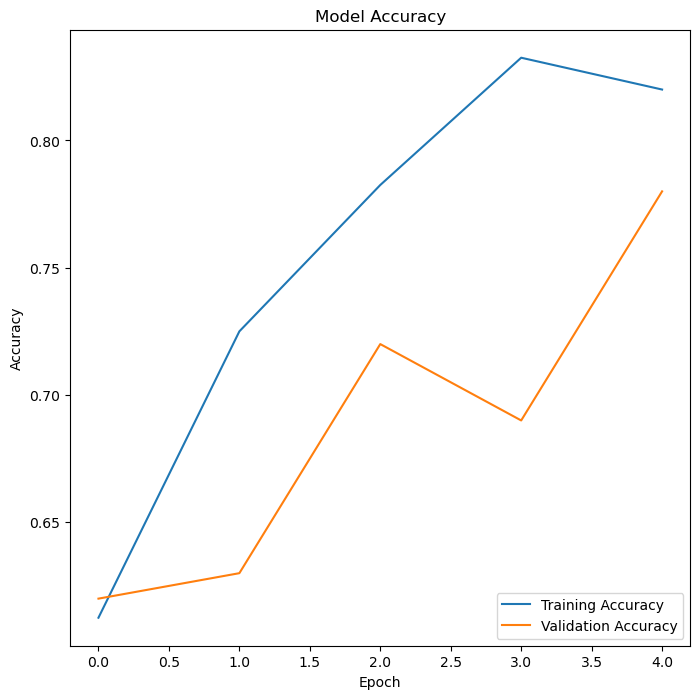

In [14]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')
plt.show()

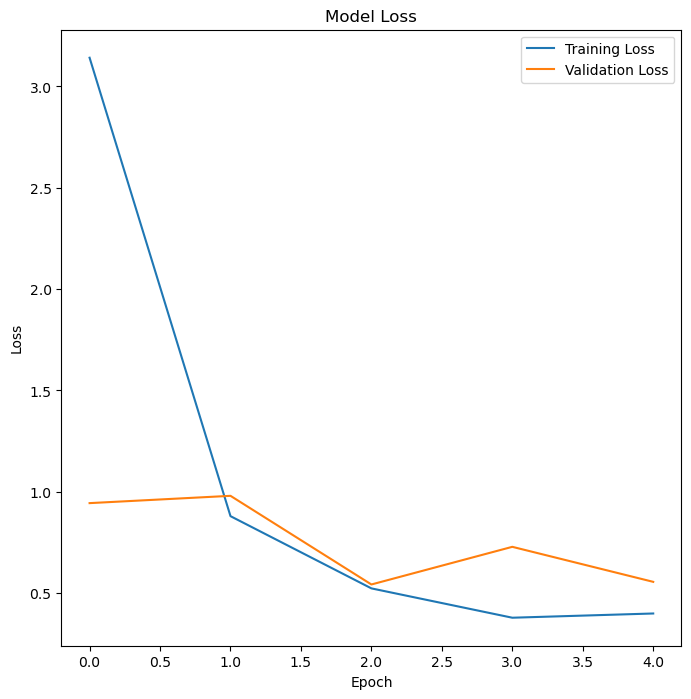

In [15]:
#Trainig loss and validation loss graph
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')
plt.show()

In [16]:
# Evaluate the model on the testing dataset
test_loss, test_acc = ensemble_model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

25/25 [==============================] - 2s 96ms/step - loss: 0.3134 - accuracy: 0.8800
Test loss: 0.3133504092693329
Test accuracy: 0.8799999952316284


In [17]:
#Compute confusion matrix
from sklearn.metrics import confusion_matrix

#Generate predictions for the test dataset
y_pred=ensemble_model.predict(test_generator)
y_pred_labels= (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes

#compute the confusion matrix
confusion= confusion_matrix(y_true, y_pred_labels)
print("Confusion Matrix:")
print(confusion)

25/25 [==============================] - 3s 92ms/step
Confusion Matrix:
[[20 30]
 [26 24]]


In [18]:
#compute f1-score
from sklearn.metrics import f1_score

f1=f1_score(y_true, y_pred_labels)
print('F1-score:', f1)

F1-score: 0.4615384615384615


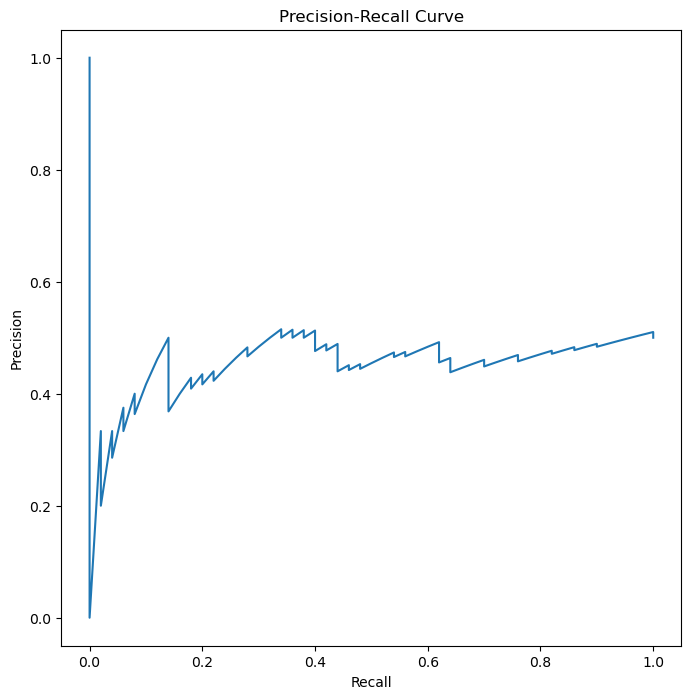

In [20]:
#compute precision-recall score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

#compute precision, recall(sensitivity), and threshold values
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

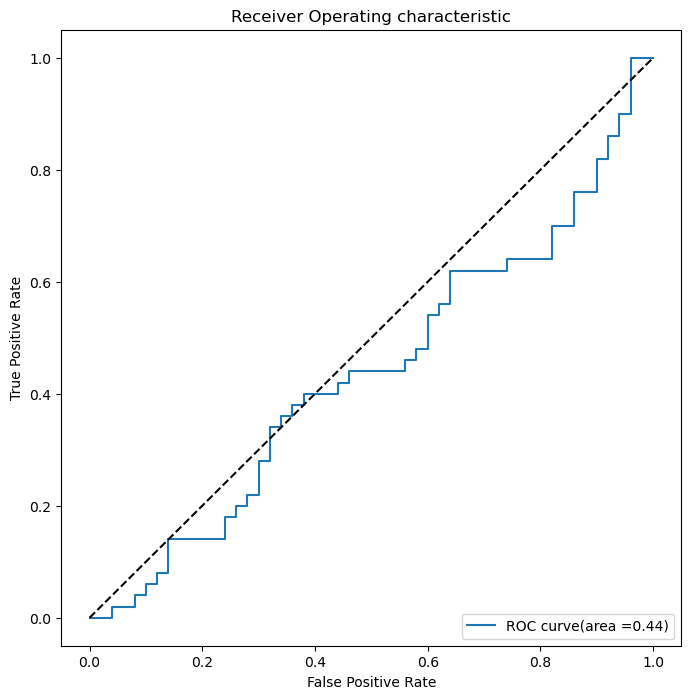

In [21]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

#compute the AUC score
roc_auc= auc(fpr, tpr)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [22]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate 
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 0.0
specificity: 0.98


In [23]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

del ensemble_model



In [24]:
#You need to install numba using 'pip install numba'

from numba import cuda

cuda.select_device(0)
cuda.close()